## Data:

Shape: (24702, 7)
Columns:
- employee_id : id of the employee. Unique by employee per company 
- company_id : company id.
- dept : employee dept
- seniority : number of yrs of work experience when hired
- salary: avg yearly salary of the employee during her tenure within the company 
- join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
- quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [1]:
import pendulum
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy import stats
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree

import shap
import lightgbm as lgb
from pydantic import BaseSettings
from sklearn.metrics import roc_auc_score, recall_score, precision_score

In [2]:
# read the table
df = pd.read_csv("./employee_retention.csv")

In [3]:
# print some samples
print(df.shape)
df.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


- employee_id, company_id: label encoded
- dept: categorical variable
- seniority, salary: continuous variables
- join_date, quit_date: str (需要先處理)

In [5]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [4]:
# 優先處理日期變數
df["join_date"] = pd.to_datetime(df["join_date"])
df["join_year"] = df["join_date"].dt.year
df["join_month"] = df["join_date"].dt.month

df["quit_date"] = pd.to_datetime(df["quit_date"])
df["quit_year"] = df["quit_date"].dt.year
df["quit_month"] = df["quit_date"].dt.month
df["job_days"] = (df["quit_date"] - df["join_date"]).dt.days.fillna(9999)
df["quit"] = df["job_days"]  != 9999

In [85]:
df[df["quit"] == 1]["job_days"].describe()

count    13510.000000
mean       613.486825
std        328.622613
min        102.000000
25%        361.000000
50%        417.000000
75%        781.000000
max       1726.000000
Name: job_days, dtype: float64

In [ ]:
# 懶人包
plt.ion()
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

### 懶人包簡易資訊
- 各變數
    - 總共12個company id, 以id=0為最多 (隨id提升而人數遞減？可能有刻意排序)
    - 共有5種dept, customer_service最多
    - seniority介於1~29, 有98, 99兩個明顯的離群值
    - salary: 右尾分布 (17000~408000)
    - join_date: 995個日期: start: 2011-01-24 ~ 2025-12-10
    - quit_date: 664個日期，有11192個NA值 (45.3%仍在職): 2011-10-13 ~ 2015-12-09
- 相關性
    - salary & seniority 正相關
    - salary is highly correlated with dept and 1 other fields (?)
        - 感覺dept 跟 salary 可以觀察

In [33]:
dept_part = pd.get_dummies(df["dept"], prefix="is")

# concat dataframes
df_oh = pd.concat([df, dept_part], axis=1)

# delete original columns
del df_oh["dept"]

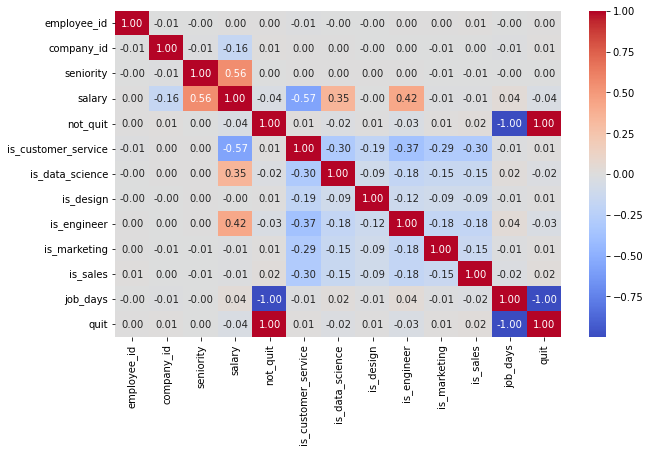

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
g=sns.heatmap(df_oh[[c for c in df_oh.columns if c not in ["join_date", "quit_date", "job_days", "quit"]] + ["job_days", "quit"]
                   ].corr(),annot=True ,fmt=".2f", cmap="coolwarm", ax=ax)

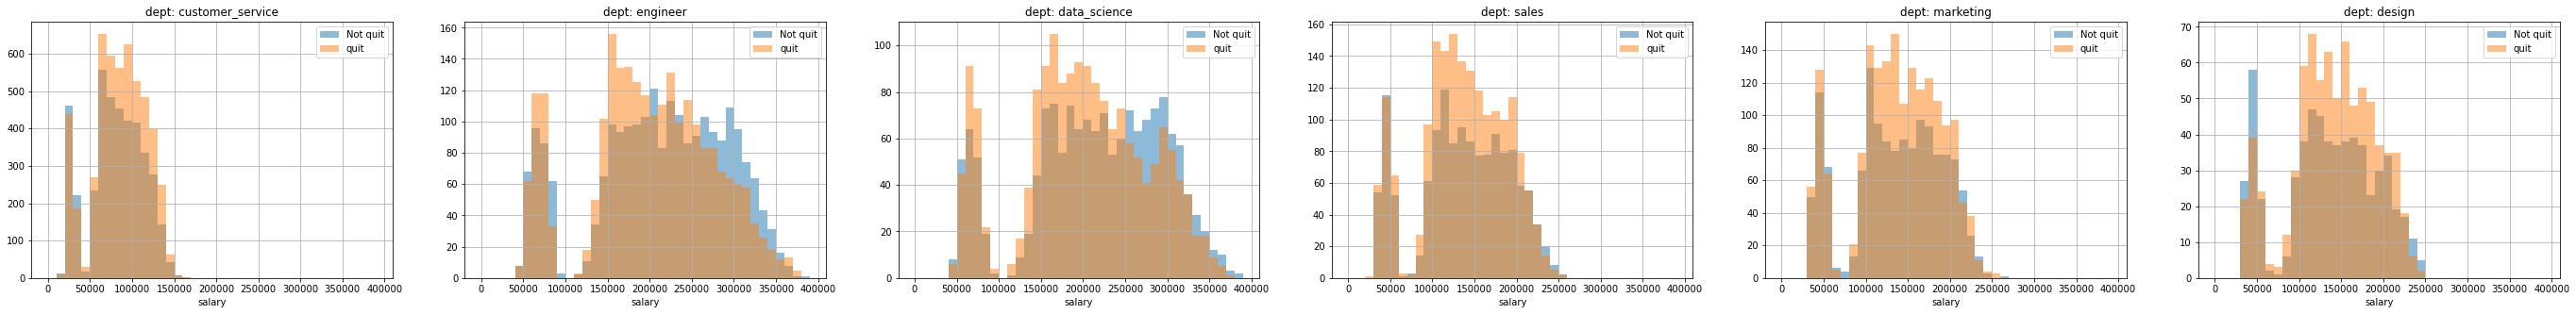

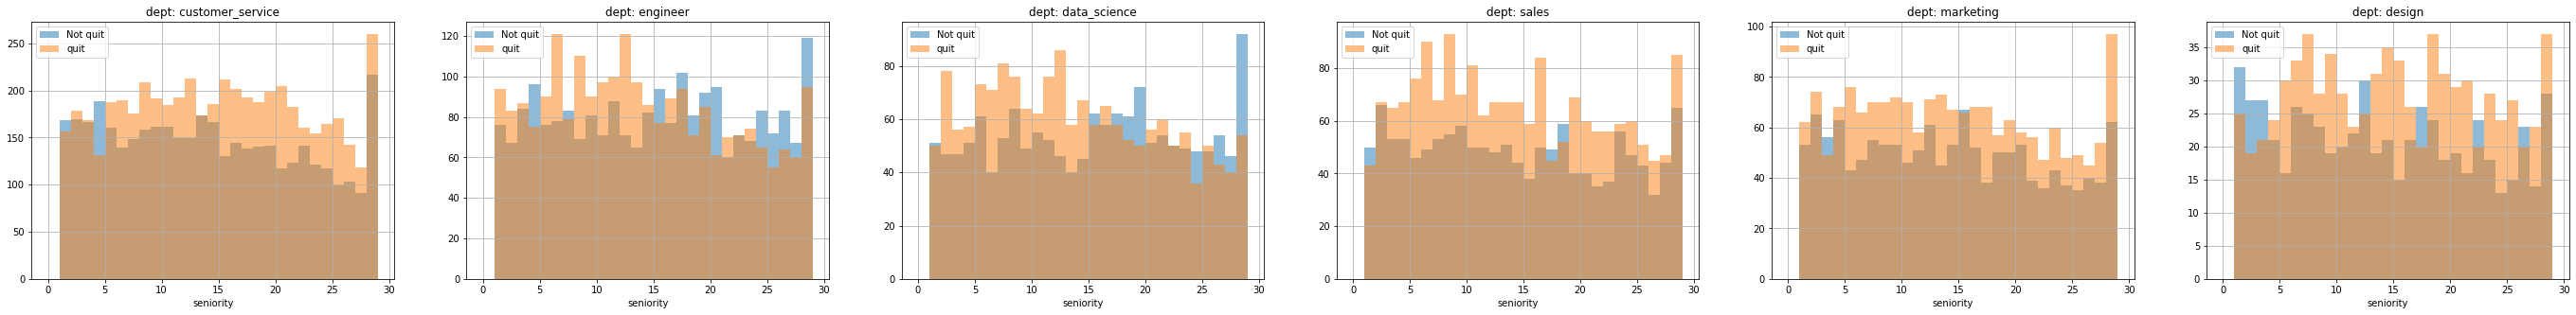

In [69]:
num_dept = len(df.dept.value_counts().index)
fig, ax = plt.subplots(1, num_dept, figsize=(8*num_dept,5))
for i, c in enumerate(df.dept.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.quit == 0)
                                    & (df.dept == c)
                                    ][["salary"]
                                 ], bins=[10000*i for i in range(40)], color = '#1f77b4', alpha=0.5, density=False, label="Not quit")


    n, bins, patches = ax[i].hist(df[(df.quit == 1)
                                    & (df.dept == c)
                                    ][["salary"]
                                 ], bins=[10000*i for i in range(40)], color = '#ff7f0e', alpha=0.5, density=False, label="quit")

    ax[i].set_title(f"dept: {c}")
    ax[i].set_xlabel("salary")
    ax[i].legend()
    ax[i].grid(True)

fig, ax = plt.subplots(1, num_dept, figsize=(8*num_dept,5))
for i, c in enumerate(df.dept.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.quit == 0)
                                    & (df.dept == c)
                                    ][["seniority"]
                                 ], bins=[1*i for i in range(30)], color = '#1f77b4', alpha=0.5, density=False, label="Not quit")


    n, bins, patches = ax[i].hist(df[(df.quit == 1)
                                    & (df.dept == c)
                                    ][["seniority"]
                                 ], bins=[1*i for i in range(30)], color = '#ff7f0e', alpha=0.5, density=False, label="quit")

    ax[i].set_title(f"dept: {c}")
    ax[i].set_xlabel("seniority")
    ax[i].legend()
    ax[i].grid(True)

- data_science, engineer的分佈
    - salary較高的人，反而不易離職
    - seniority較高的人，反而不易離職
- others:
    - salary較低的人，反而不易離職
    - seniority較低的人，反而不易離職

In [72]:
# ref: https://github.com/ShinminHsu/DS-study-group/blob/shinmin_hsu/01_conversion_rate.ipynb
# Note: update seaborn pkg to latest version, or might occur errors.
def plot_conversion_rate_categorical(df, target, control="conversion"):
    
    custom_params = {"axes.spines.top": False, "font.size": 16}
    sns.set_theme(style="ticks", palette="Set2", font_scale=2, rc=custom_params)

    # calculate the conversion rate and the number of users for each target of interest
    total = df.groupby(target)[control].count().reset_index()
    total[target] = total[target].astype(str)
    group = df[[target, control]].groupby(target).mean().reset_index()
    order_list = group[target]

    fig, g1 = plt.subplots(figsize=(40, 8))
    g2 = g1.twinx()

    # barplot
    sns.countplot(df, x=target, hue=control, order=order_list, ax=g1)
    g1.set_yscale("log")

    # lineplot: to show conversion rate
    g2.plot(group[target].astype(str), group[control], color="dimgrey", marker='o', linestyle='dashed',
         linewidth=2, markersize=8)
    if control == "conversion":
        g2.set(ylim=(0, 0.1))

    # annotation
    for i in range(group.shape[0]):
        x = group.iloc[i][target] - group[target].iloc[0]
        y = group.iloc[i][control]
        label = f"{y*100:.2f}%"

        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color="dimgrey")
        
    # add the number of users for each target of interest to x labels
    labels = [item.get_text() for item in g1.get_xticklabels()]
    labels = [f"{label} \n {total[total[target] == label][control].values[0]:,}" for label in labels]
    g1.set_xticklabels(labels)
    
    fig.text(0.06, 0, 'Note: Numbers under labels are the total number for each label', ha='left', fontsize=20)
    
    plt.title(f"{control} rate by {target}", fontsize=25, pad=40)
    plt.tight_layout()
    plt.show()

<ipython-input-72-3f40464daa34>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


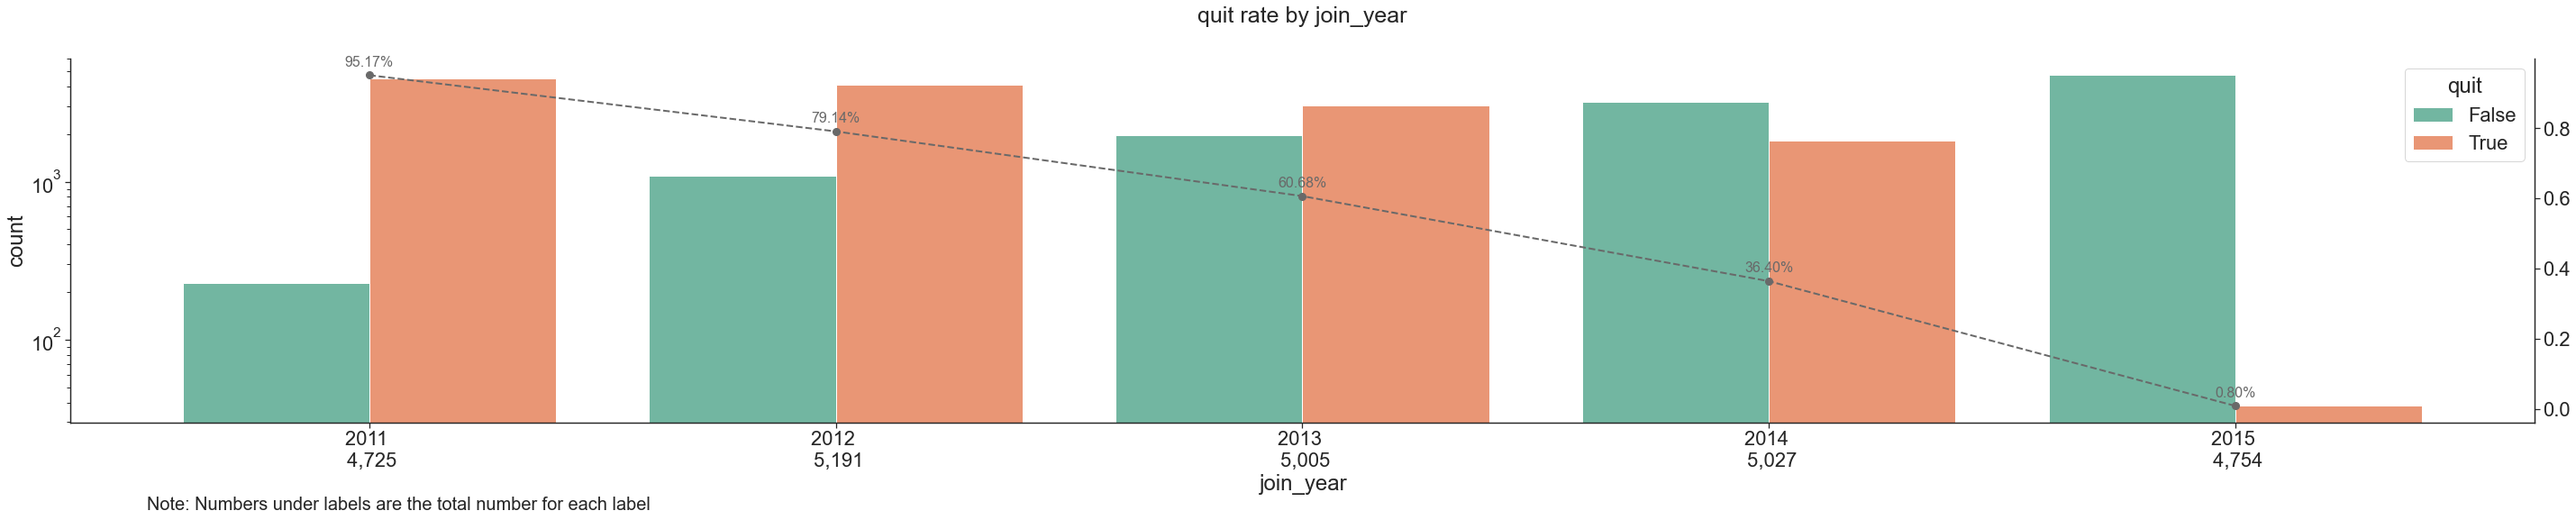

In [73]:
plot_conversion_rate_categorical(df, target="join_year", control="quit")

<ipython-input-72-3f40464daa34>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


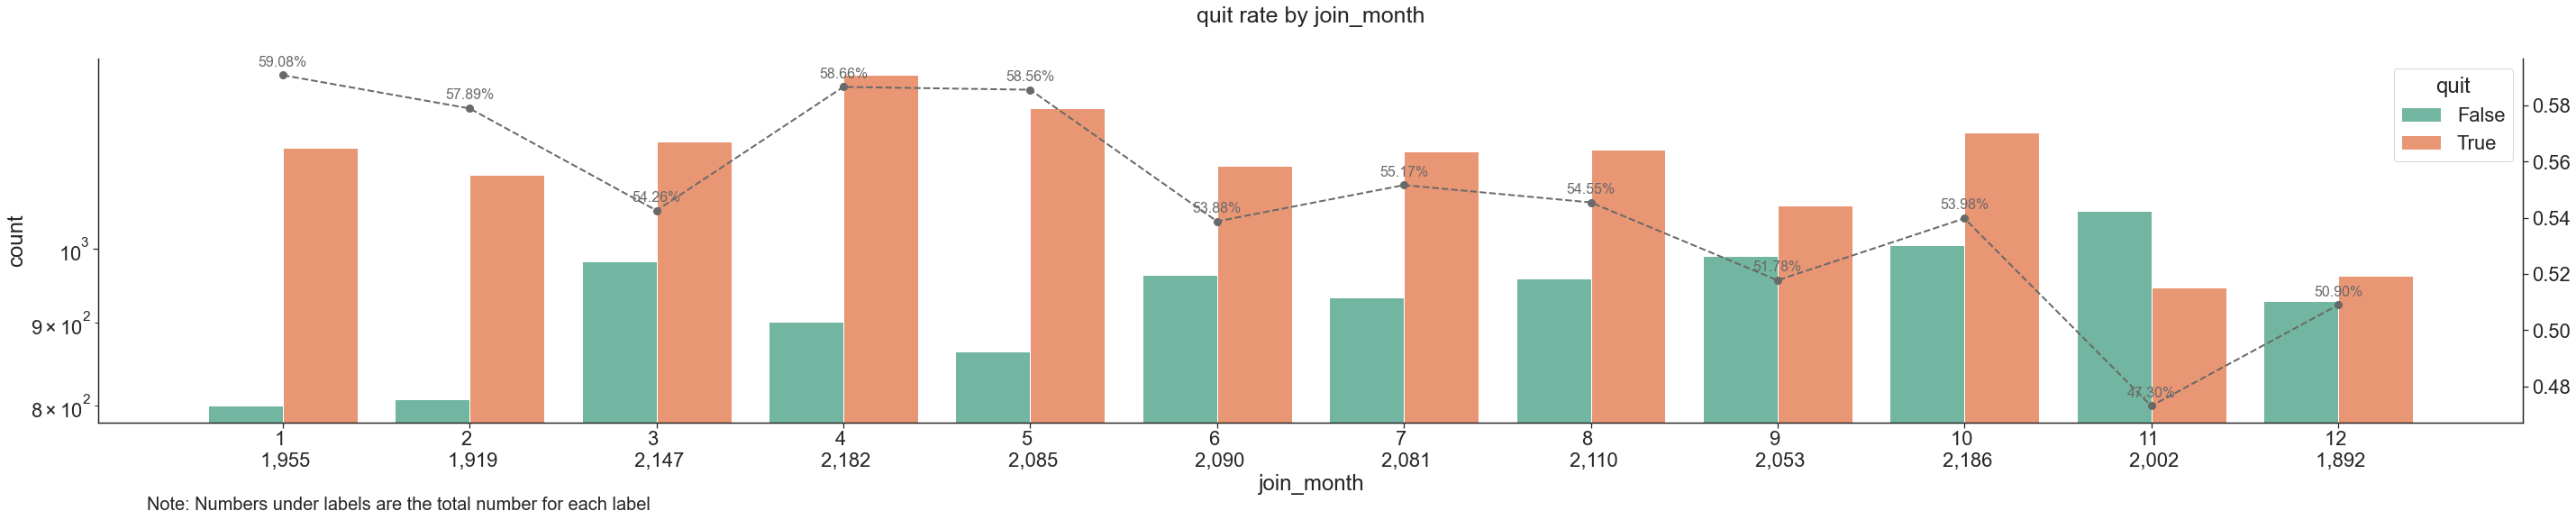

In [74]:
plot_conversion_rate_categorical(df, target="join_month", control="quit")

- join_year 逐年下降 (越接近end_date的越不容易churn，工作時間越短)
- join_month 在 11, 12月較不容易churn (接近年終？可以推測這時段加入的人，也是比較接近滿週年的員工)

<ipython-input-72-3f40464daa34>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


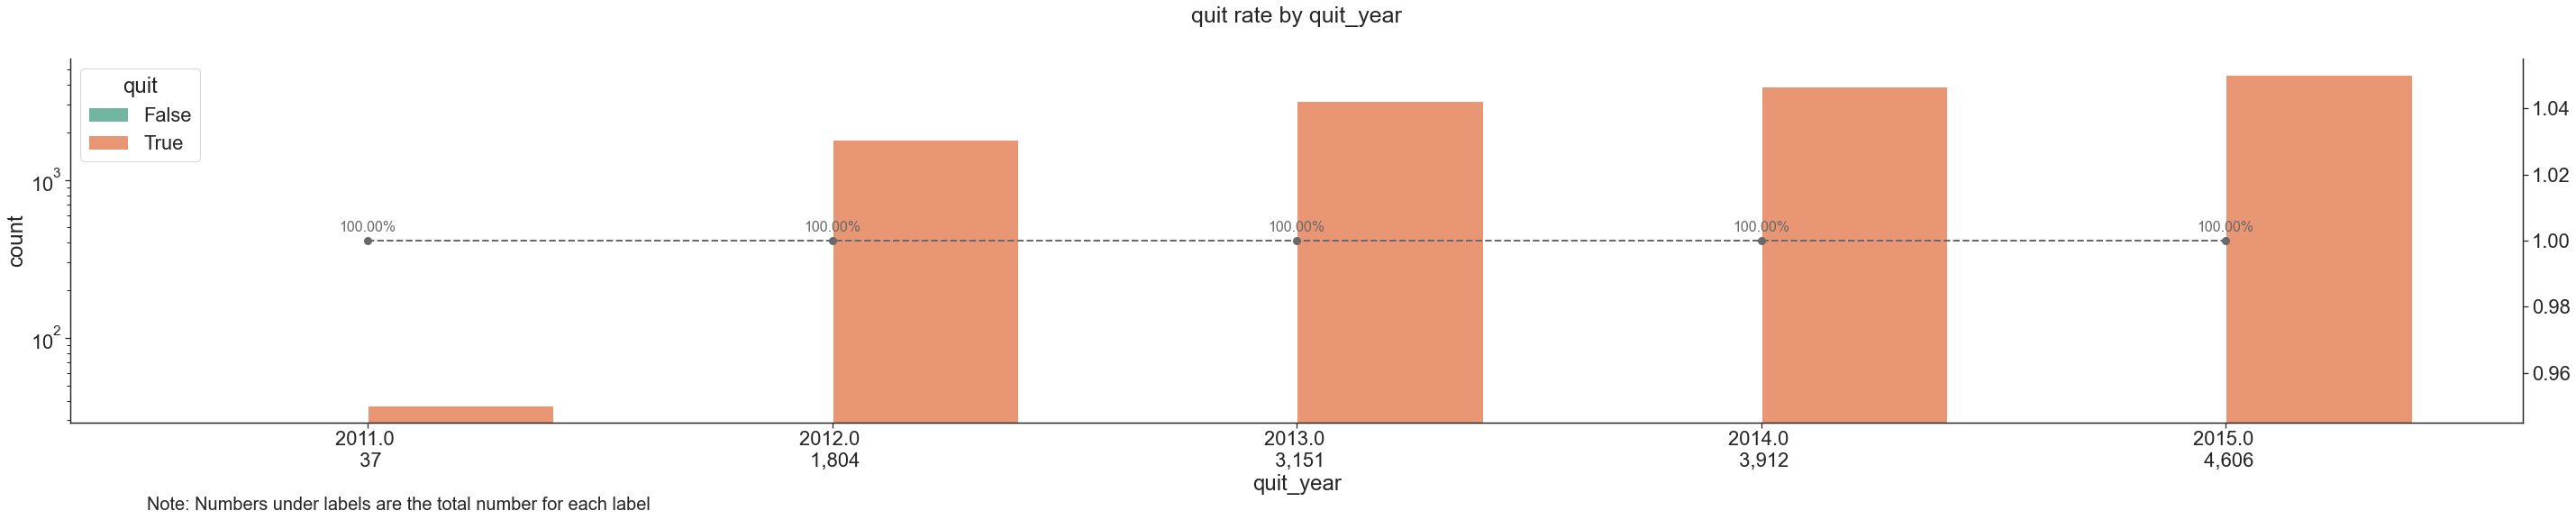

In [76]:
plot_conversion_rate_categorical(df, target="quit_year", control="quit")

<ipython-input-72-3f40464daa34>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


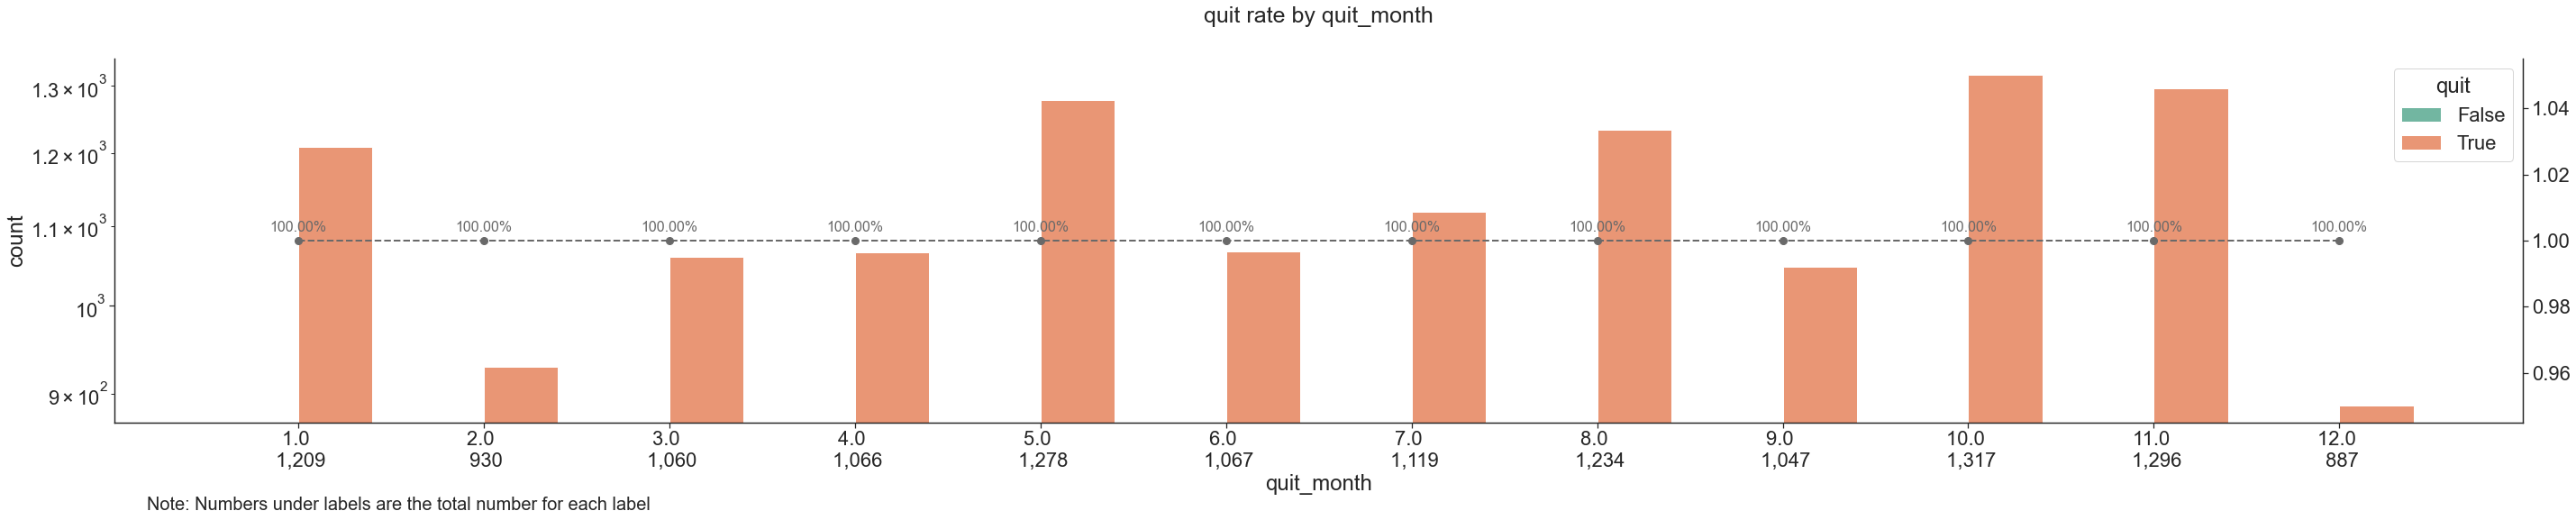

In [77]:
plot_conversion_rate_categorical(df, target="quit_month", control="quit")

- quit_year 逐年上升 (已經工作時間久的人越多，因此越多人離職)
- quit_month 在12月較不容易churn (同理年終？)

<ipython-input-69-65a6ceef3d48>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


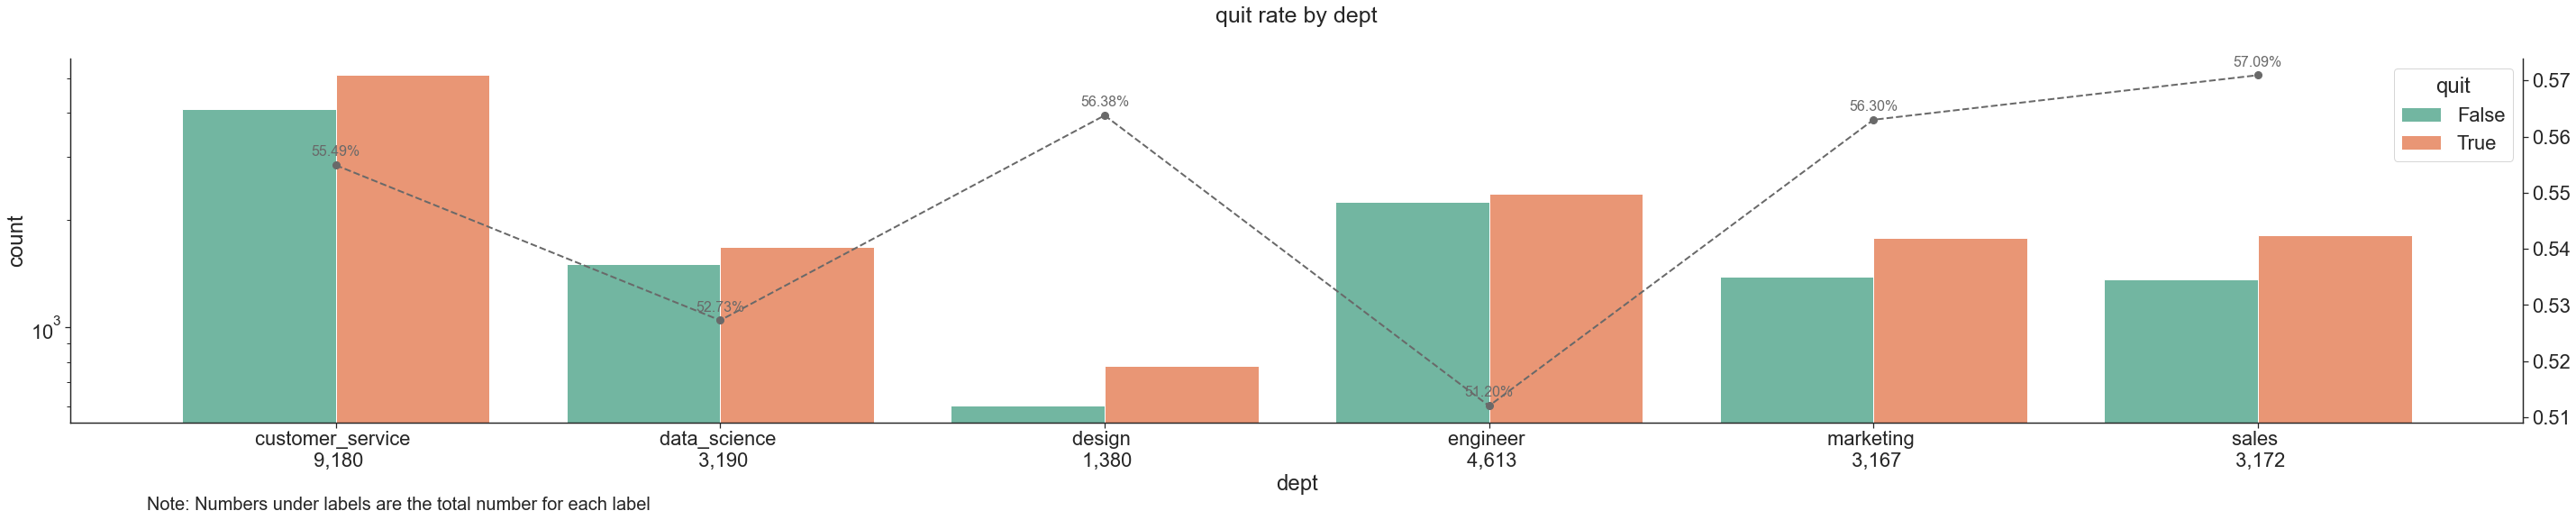

In [71]:
plot_conversion_rate_categorical(df, target="dept", control="quit")

- 各職業的churn rate 落在50~60%之間
- engineer, data_science的churn rate最低 (相對穩定的職業？)

<ipython-input-80-3f40464daa34>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


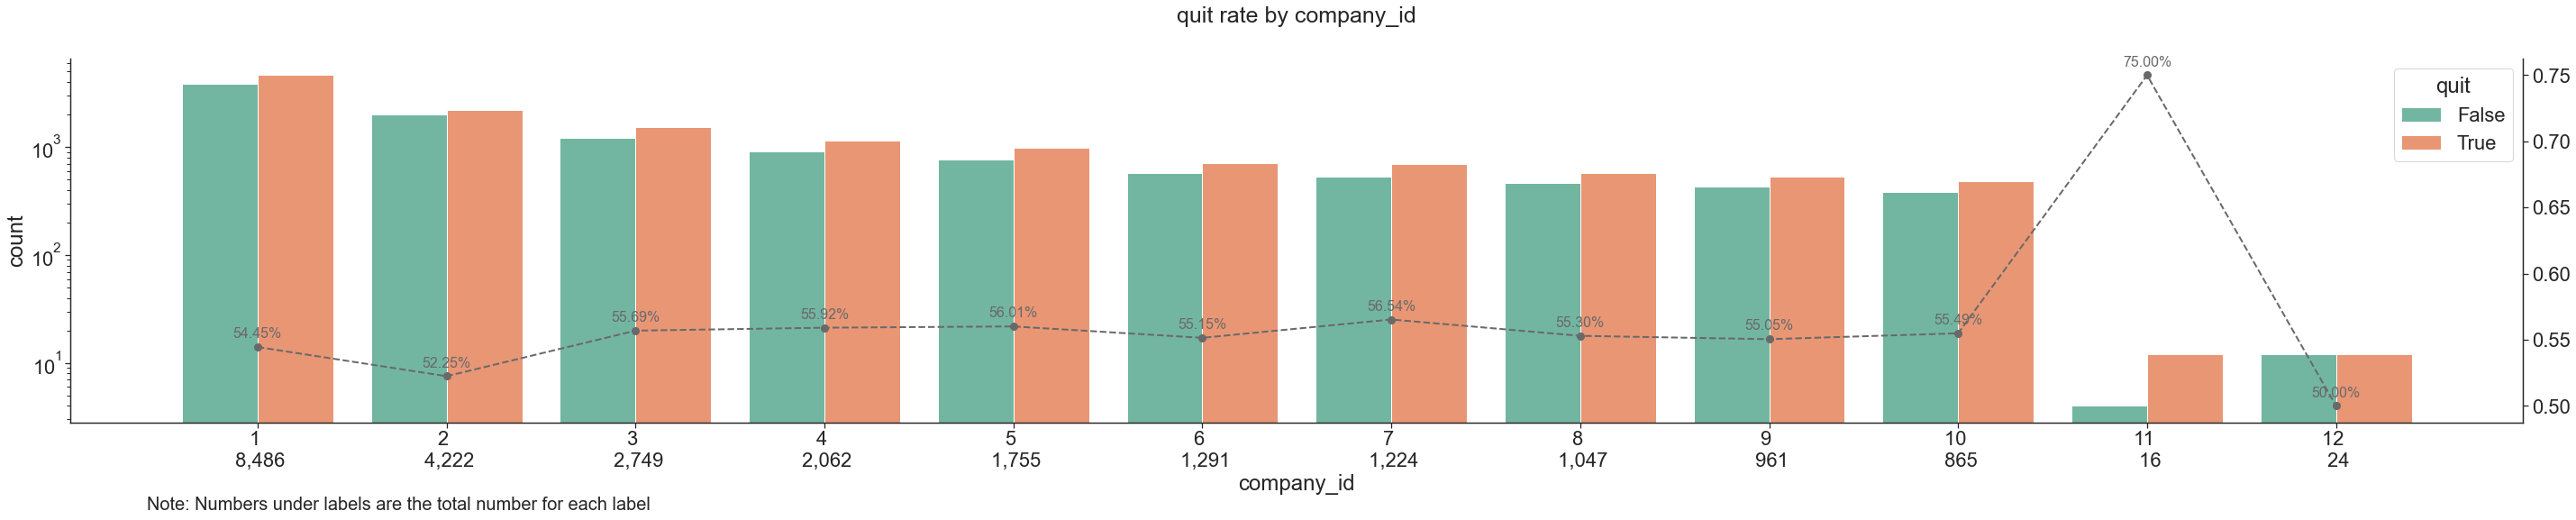

In [81]:
plot_conversion_rate_categorical(df, target="company_id", control="quit")

- 除了company_id=11, 12(樣本數太低)
    - company_id=2 churn rate最低 (52.25%)
    - company_id=7 churn rate最高 (56.54%)
    - 人數多的公司，離職的比例相對較低 (但沒有低很多)

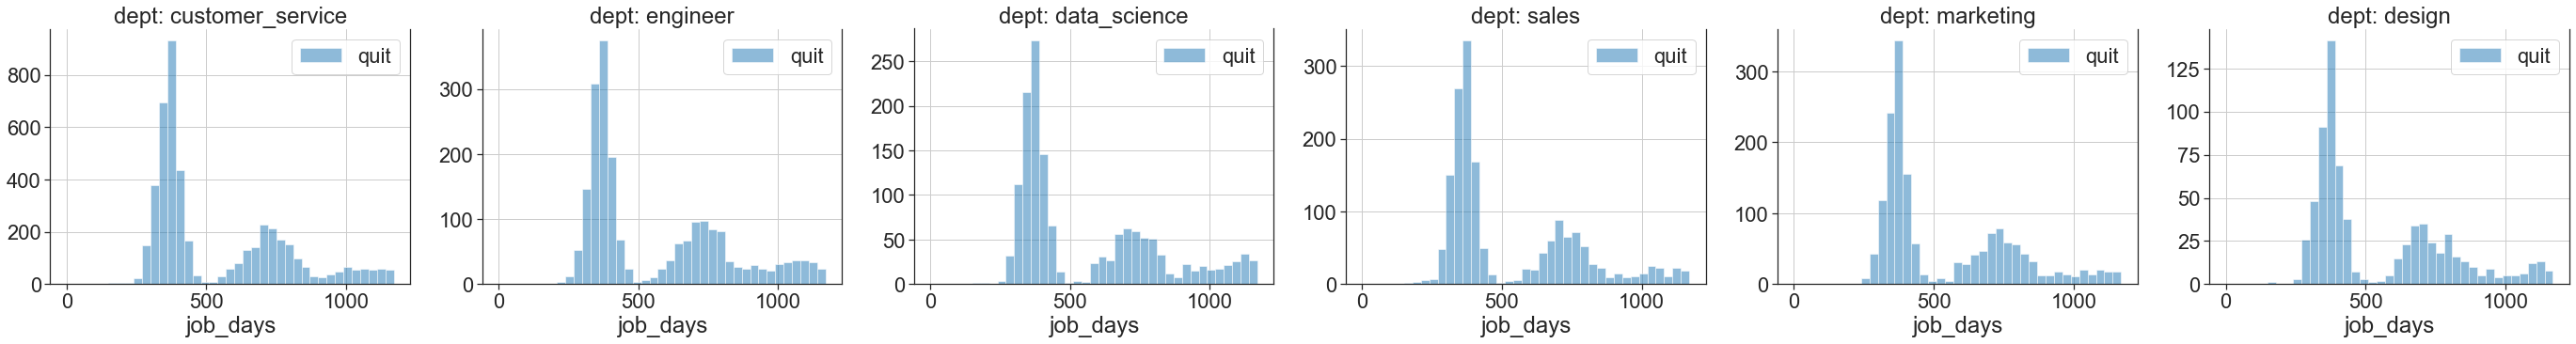

In [87]:
num_dept = len(df.dept.value_counts().index)
fig, ax = plt.subplots(1, num_dept, figsize=(8*num_dept,5))
for i, c in enumerate(df.dept.value_counts().index):
    # the histogram of the data
    n, bins, patches = ax[i].hist(df[(df.quit == 1)
                                    & (df.dept == c)
                                    ][["job_days"]
                                 ], bins=[30*i for i in range(40)], color = '#1f77b4', alpha=0.5, density=False, label="quit")

    ax[i].set_title(f"dept: {c}")
    ax[i].set_xlabel("job_days")
    ax[i].legend()
    ax[i].grid(True)

- 觀察不同職業的工作天數 (已離職員工)
    - 有兩個明顯的peak (nth years anniversary?)
- 職業間的分佈沒有差太多

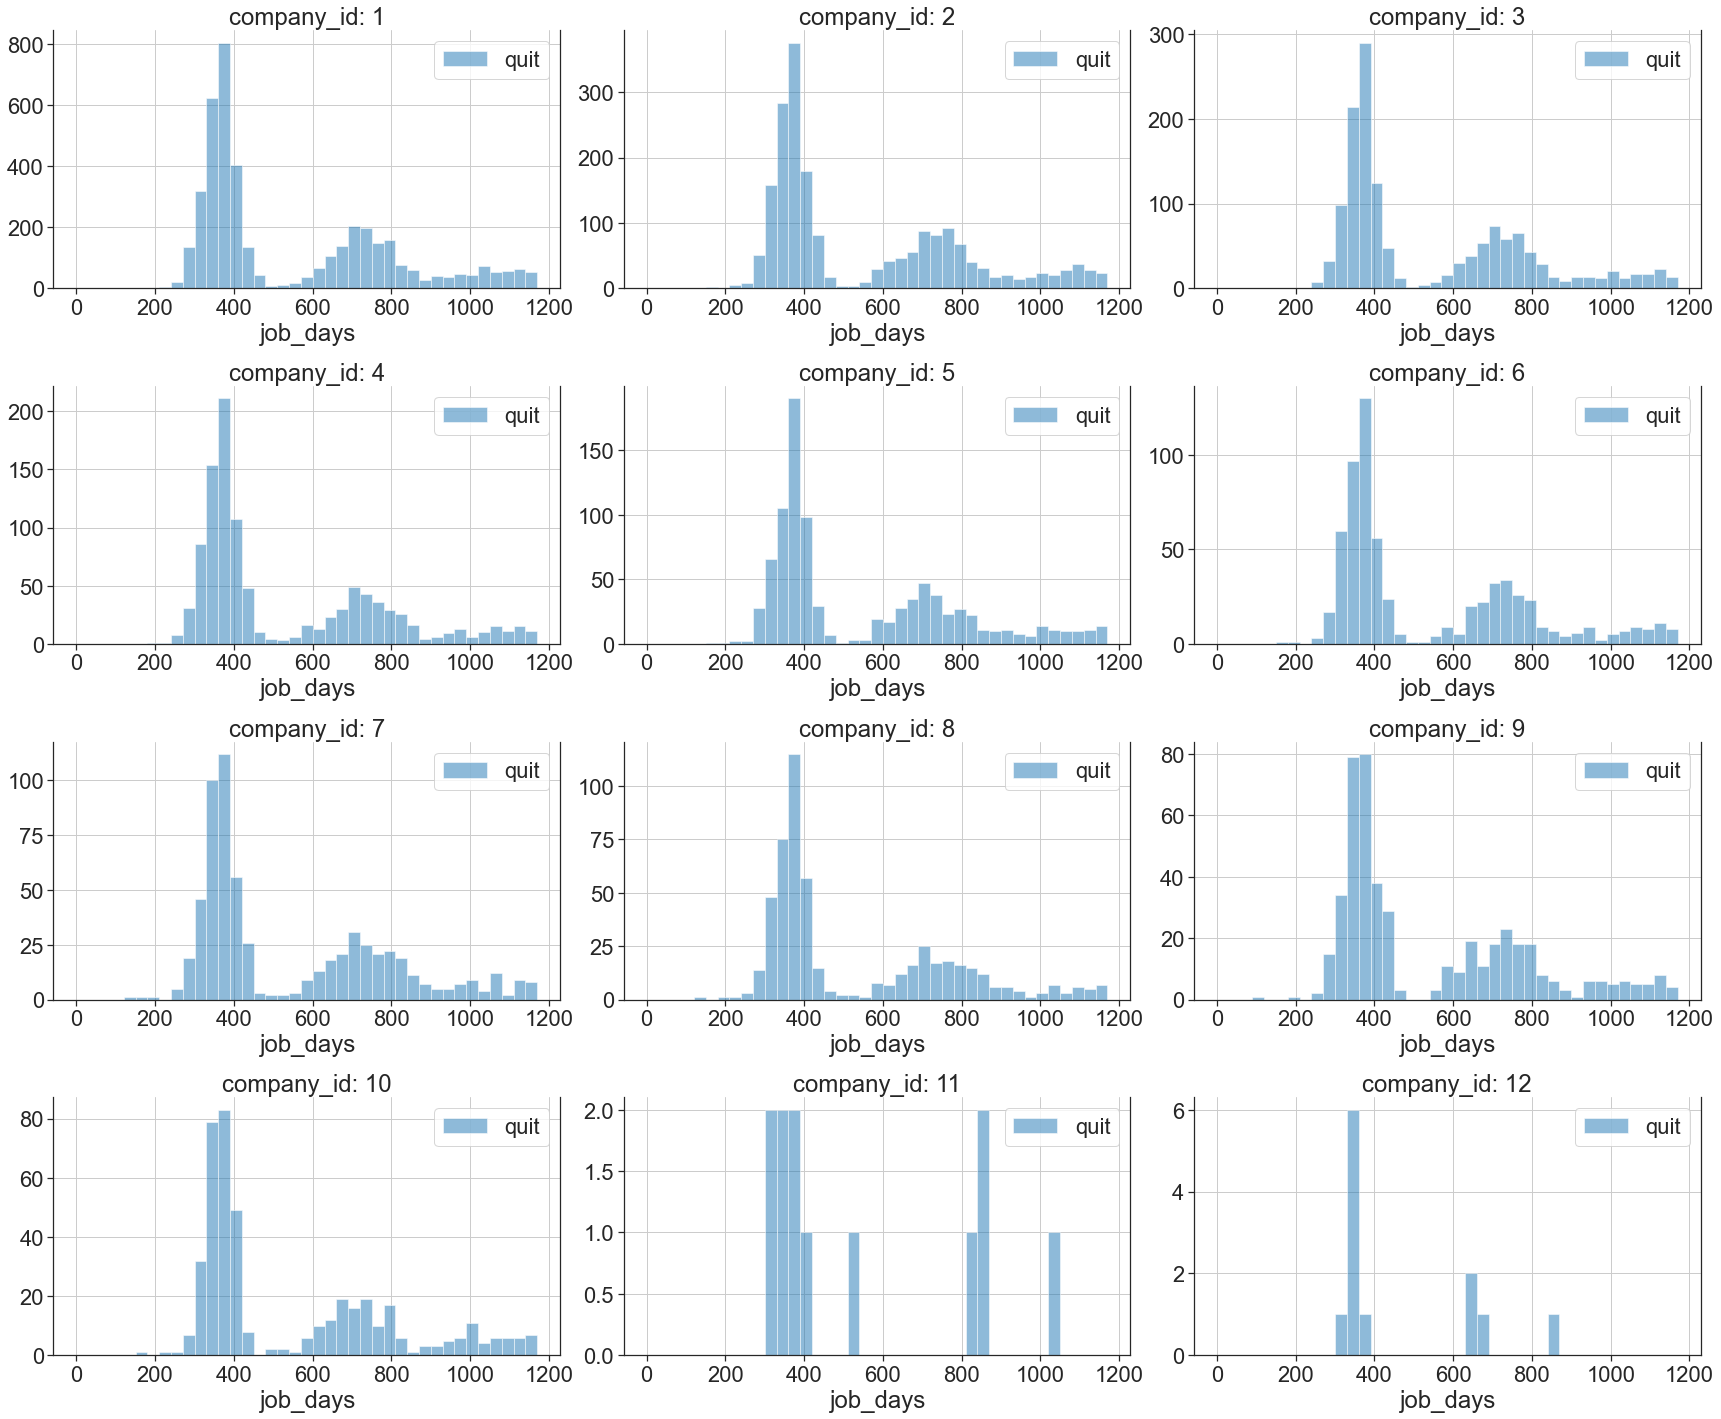

In [102]:
fig, ax = plt.subplots(4, 3, figsize=(8*3,5*4))
for i, c in enumerate(df.company_id.value_counts().sort_index().index):
    # the histogram of the data
    n, bins, patches = ax[i//3, i % 3].hist(df[(df.quit == 1)
                                    & (df.company_id == c)
                                    ][["job_days"]
                                 ], bins=[30*i for i in range(40)], color = '#1f77b4', alpha=0.5, density=False, label="quit")

    ax[i//3, i % 3].set_title(f"company_id: {c}")
    ax[i//3, i % 3].set_xlabel("job_days")
    ax[i//3, i % 3].legend()
    ax[i//3, i % 3].grid(True)
plt.tight_layout()

- 觀察不同公司的工作天數 (已離職員工)
    - 有兩個明顯的peak (nth years anniversary?)
- 公司間的分佈也沒有差太多

# Q1
Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.

In [79]:
def create_headcount_table(df, date, company_id):
    num_head_count = df[(df.join_date <= date)
                       & ((df.quit_date > date) | (df.quit == 0))
                       & (df.company_id == company_id)
                       ].shape[0]
    return [date, num_head_count, company_id]

def still_alive(x, date):
    return ((x.join_date <= date) & (x.quit_date > date)| (x.quit == 0))

In [80]:
%%time
# join_date: 995個日期: start: 2011-01-24 ~ 2025-12-10
# quit_date: 664個日期，有11192個NA值 (表示仍在職): 2011-10-13 ~ 2015-12-09
start = pendulum.parser.parse("2011-01-24")
end = pendulum.parser.parse("2015-12-13")
result = []
for c_id in range(1, 13):
    df_c = df[df.company_id == c_id]
    for d in pendulum.period(start, end).range("days"):   
        result.append(create_headcount_table(df_c, pd.to_datetime(d).tz_localize(None), c_id))

CPU times: user 29.6 s, sys: 326 ms, total: 30 s
Wall time: 30.8 s


In [81]:
# show result
df_hc = pd.DataFrame(result, columns=["date", "employee_headcount", "company_id"]).sort_values(["date", "company_id"])
df_hc["headcount_diff"] = df_hc["employee_headcount"].diff()

In [82]:
%%time
result = pd.DataFrame([], columns=["date", "employee_headcount", "company_id"])
for d in pendulum.period(start, end).range("days"):
    df_tmp = pd.DataFrame(df.groupby([df.company_id]).apply(
        lambda x: still_alive(x, pd.to_datetime(d).tz_localize(None)).sum()).reset_index())
    df_tmp.columns = ["company_id", "employee_headcount"]
    df_tmp["date"] = d.strftime("%Y-%m-%d")
    result = result.append(df_tmp)

CPU times: user 35.1 s, sys: 535 ms, total: 35.6 s
Wall time: 36.9 s


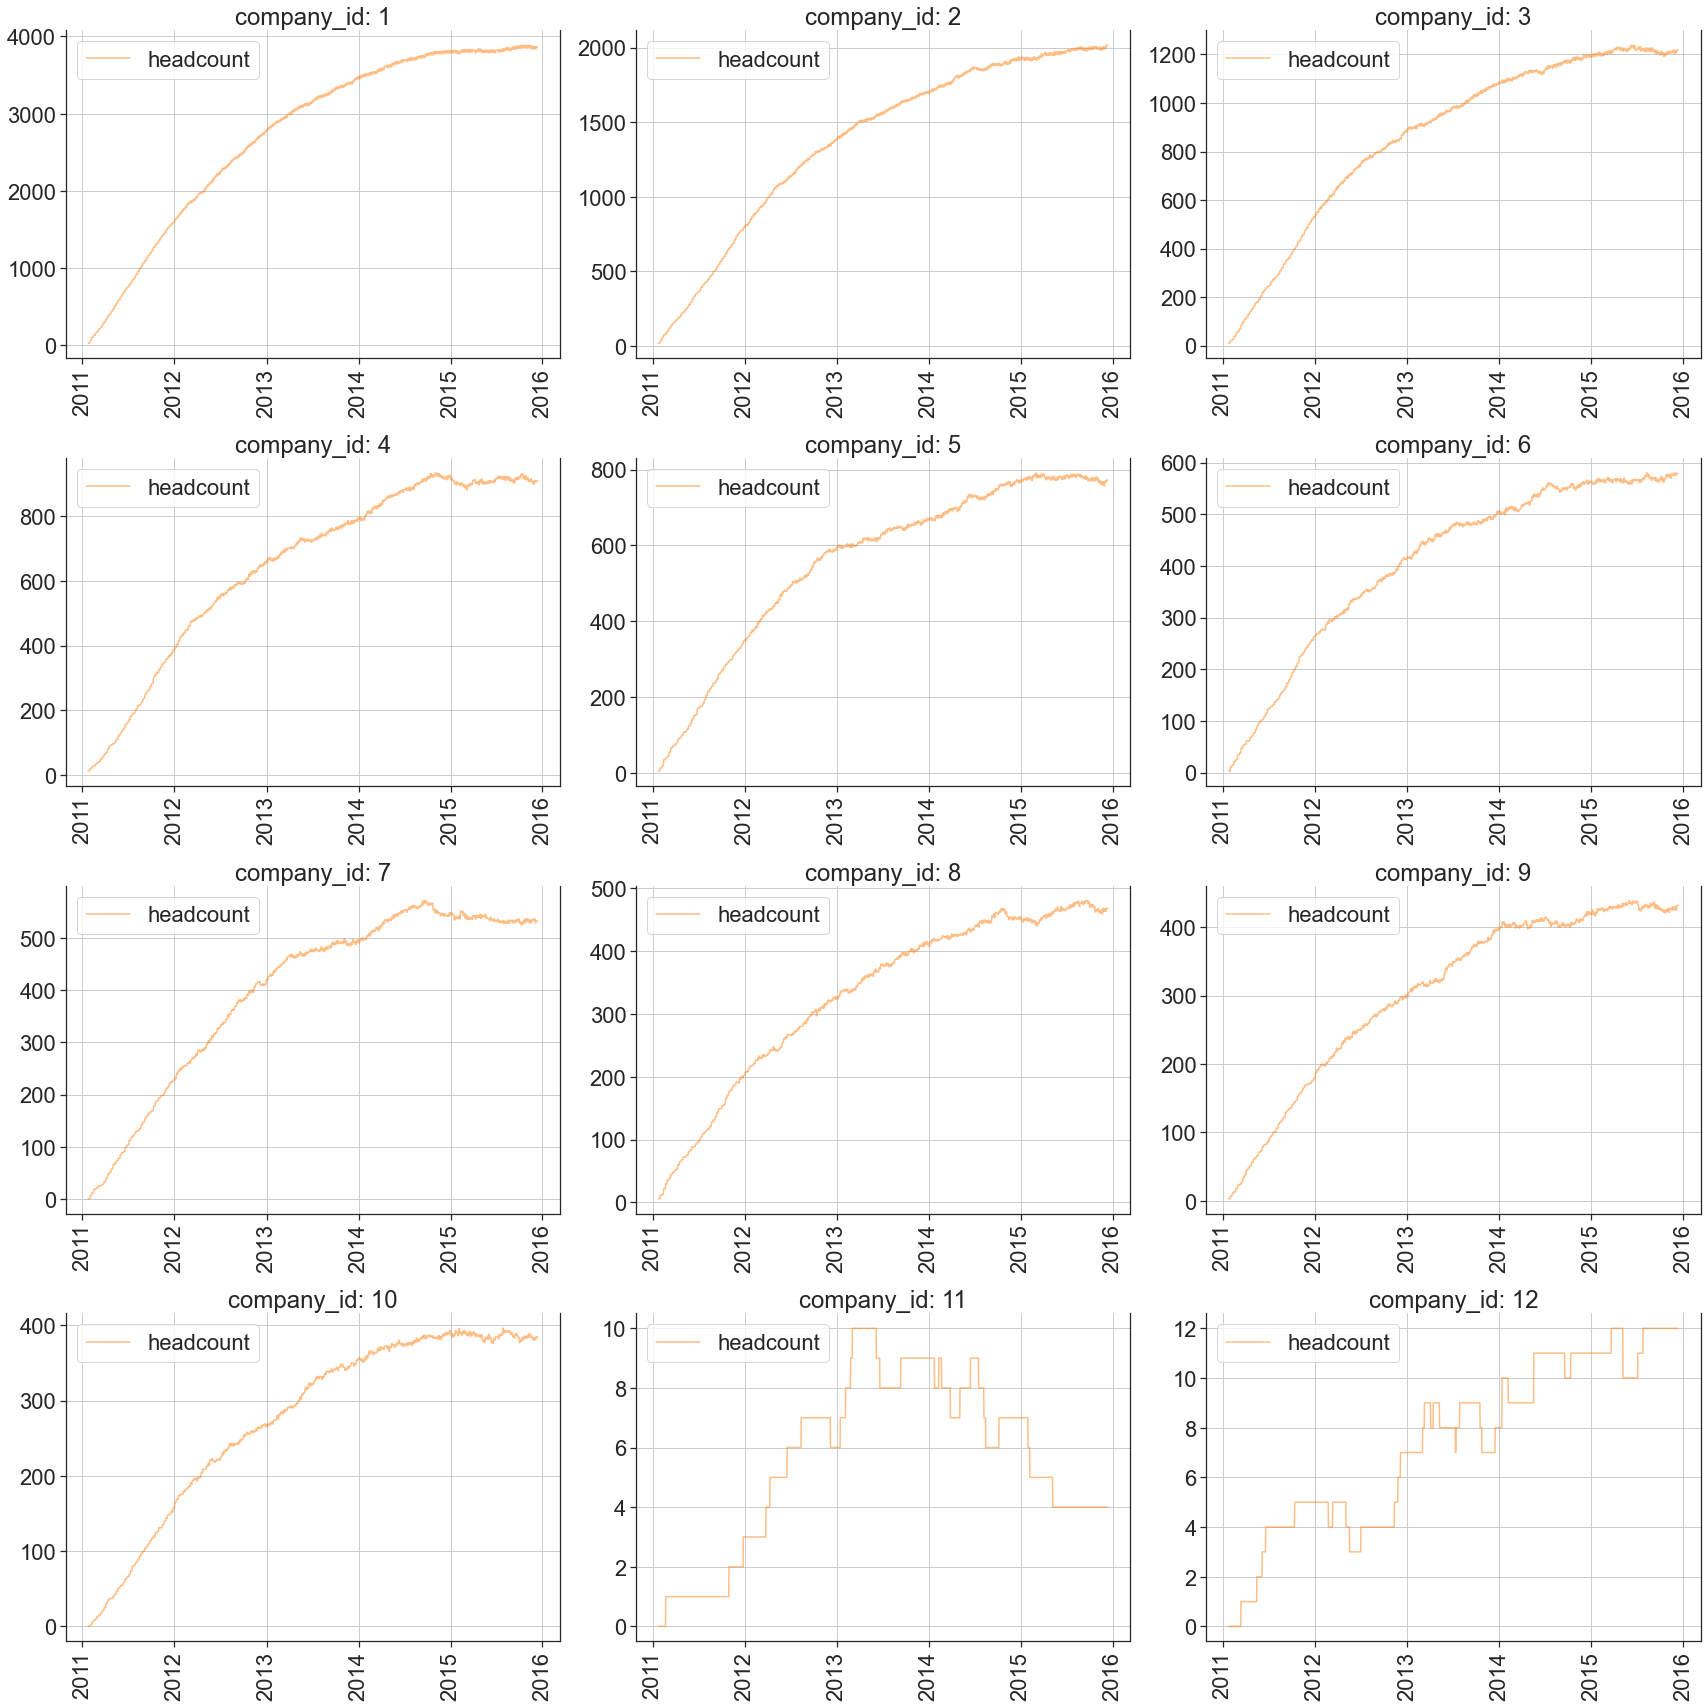

In [270]:
fig, ax = plt.subplots(4, 3, figsize=(8*3,6*4))
for i, c in enumerate(df.company_id.value_counts().sort_index().index):
    # the histogram of the data
    x = df_hc[(df_hc.company_id == c)]["date"]
    y = df_hc[(df_hc.company_id == c)]["employee_headcount"]
    ax[i//3, i % 3].plot(x, y, color = '#ff7f0e', alpha=0.5, label="headcount")
    ax[i//3, i % 3].set_title(f"company_id: {c}")
    ax[i//3, i % 3].legend()
    ax[i//3, i % 3].grid(True)
    ax[i//3, i % 3].tick_params(axis='x', rotation=90)
plt.tight_layout()

- headcount到最後都趨於穩定，到飽和狀態 (除了company_id=11, 12)
    - input = output

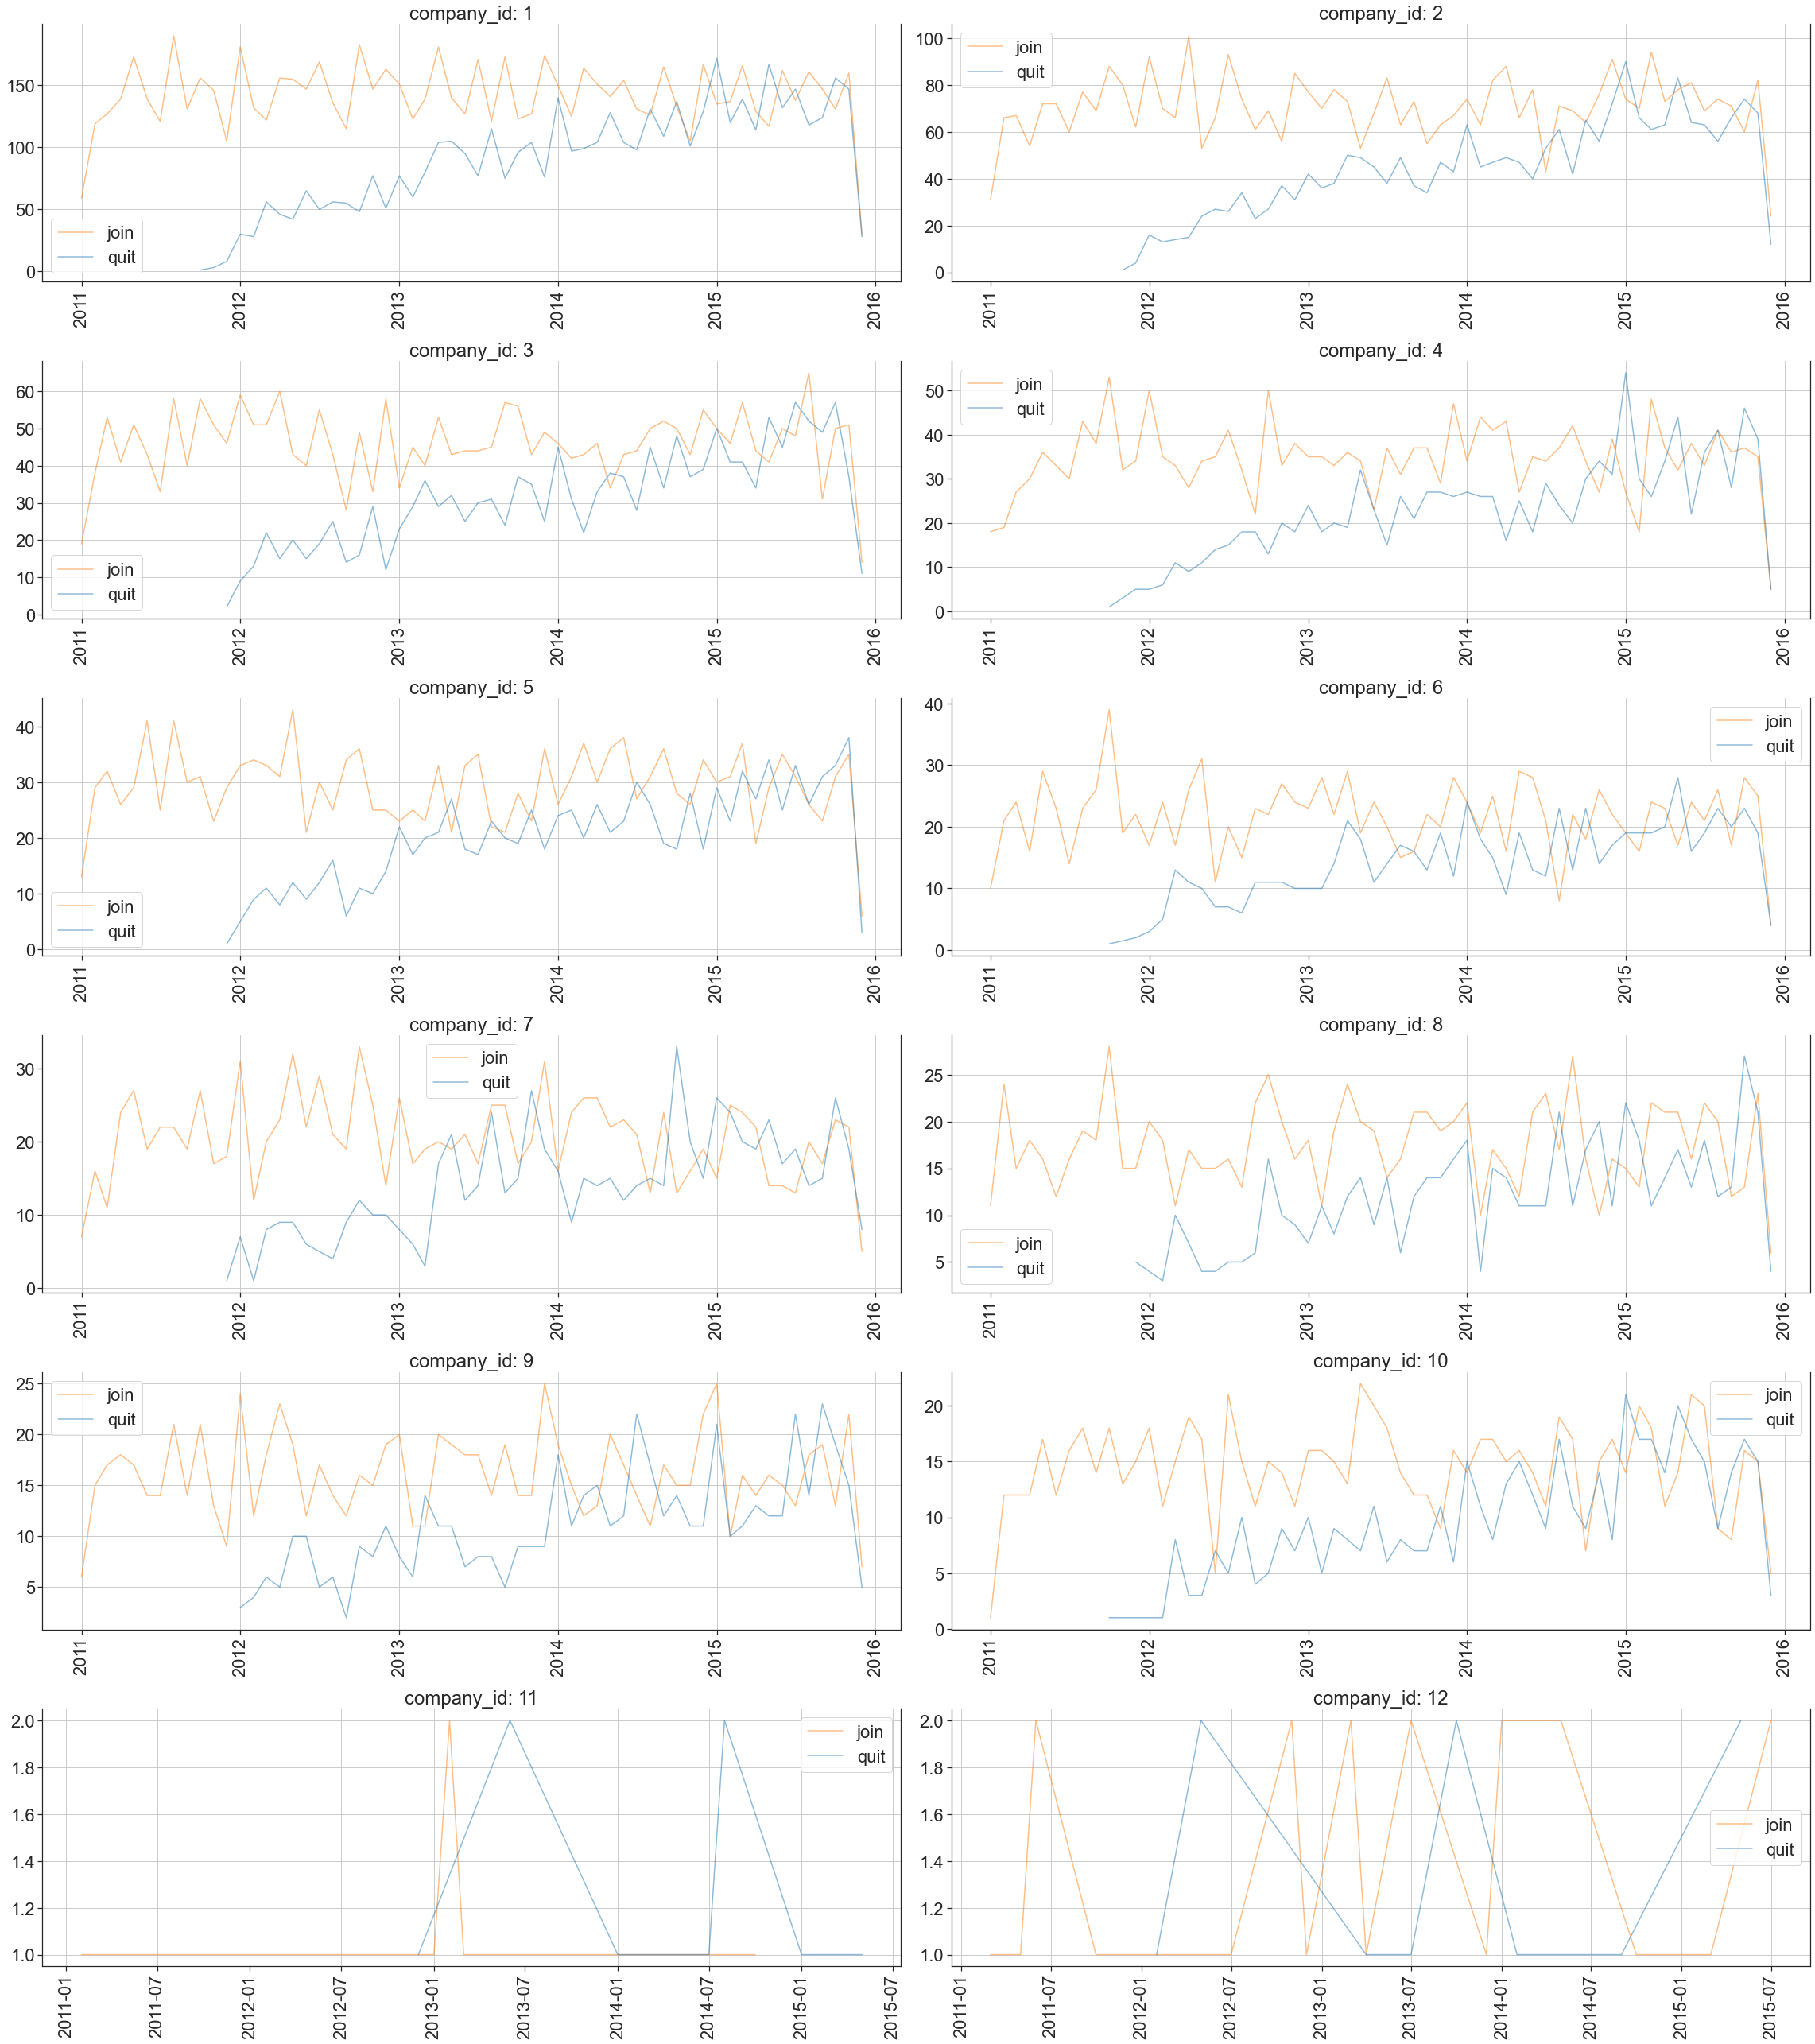

In [385]:
n_row = 6
n_col = 2
fig, ax = plt.subplots(n_row, n_col, figsize=(16*n_col,6*n_row))
for i, c in enumerate(df.company_id.value_counts().sort_index().index):
#     ax_ = ax[i//n_col, i % n_col].twinx()
    # the histogram of the data
    y1 = df[(df.company_id == c)].groupby([df.join_date.dt.year, df.join_date.dt.month]).count()["quit"]
    y2 = df[(df.quit == 1) & (df.company_id == c)].groupby([df.quit_date.dt.year, df.quit_date.dt.month]).count()["quit"]

    x1 = [pd.to_datetime(f"{int(x[0])}-{int(x[1])}") for x in y1.index]
    x2 = [pd.to_datetime(f"{int(x[0])}-{int(x[1])}") for x in y2.index]
    
#     df1 = pd.DataFrame([x1, y1]).T
#     df1.index = x1

#     df2 = pd.DataFrame([x2, y2]).T
#     df2.index = x2
    
#     df3 = df2[1].div(df1[1])
    
    ax[i//n_col, i % n_col].plot(x1, y1, color = '#ff7f0e', alpha=0.5, label="join")
    ax[i//n_col, i % n_col].plot(x2, y2, color = '#1f77b4', alpha=0.5, label="quit")
#     ax_.plot(df3.index, df3.values, color = '#2ca02c', alpha=0.5, label="diff")
    
    ax[i//n_col, i % n_col].set_title(f"company_id: {c}")
    ax[i//n_col, i % n_col].legend()
    ax[i//n_col, i % n_col].grid(True)
    ax[i//n_col, i % n_col].tick_params(axis='x', rotation=90)
plt.tight_layout()

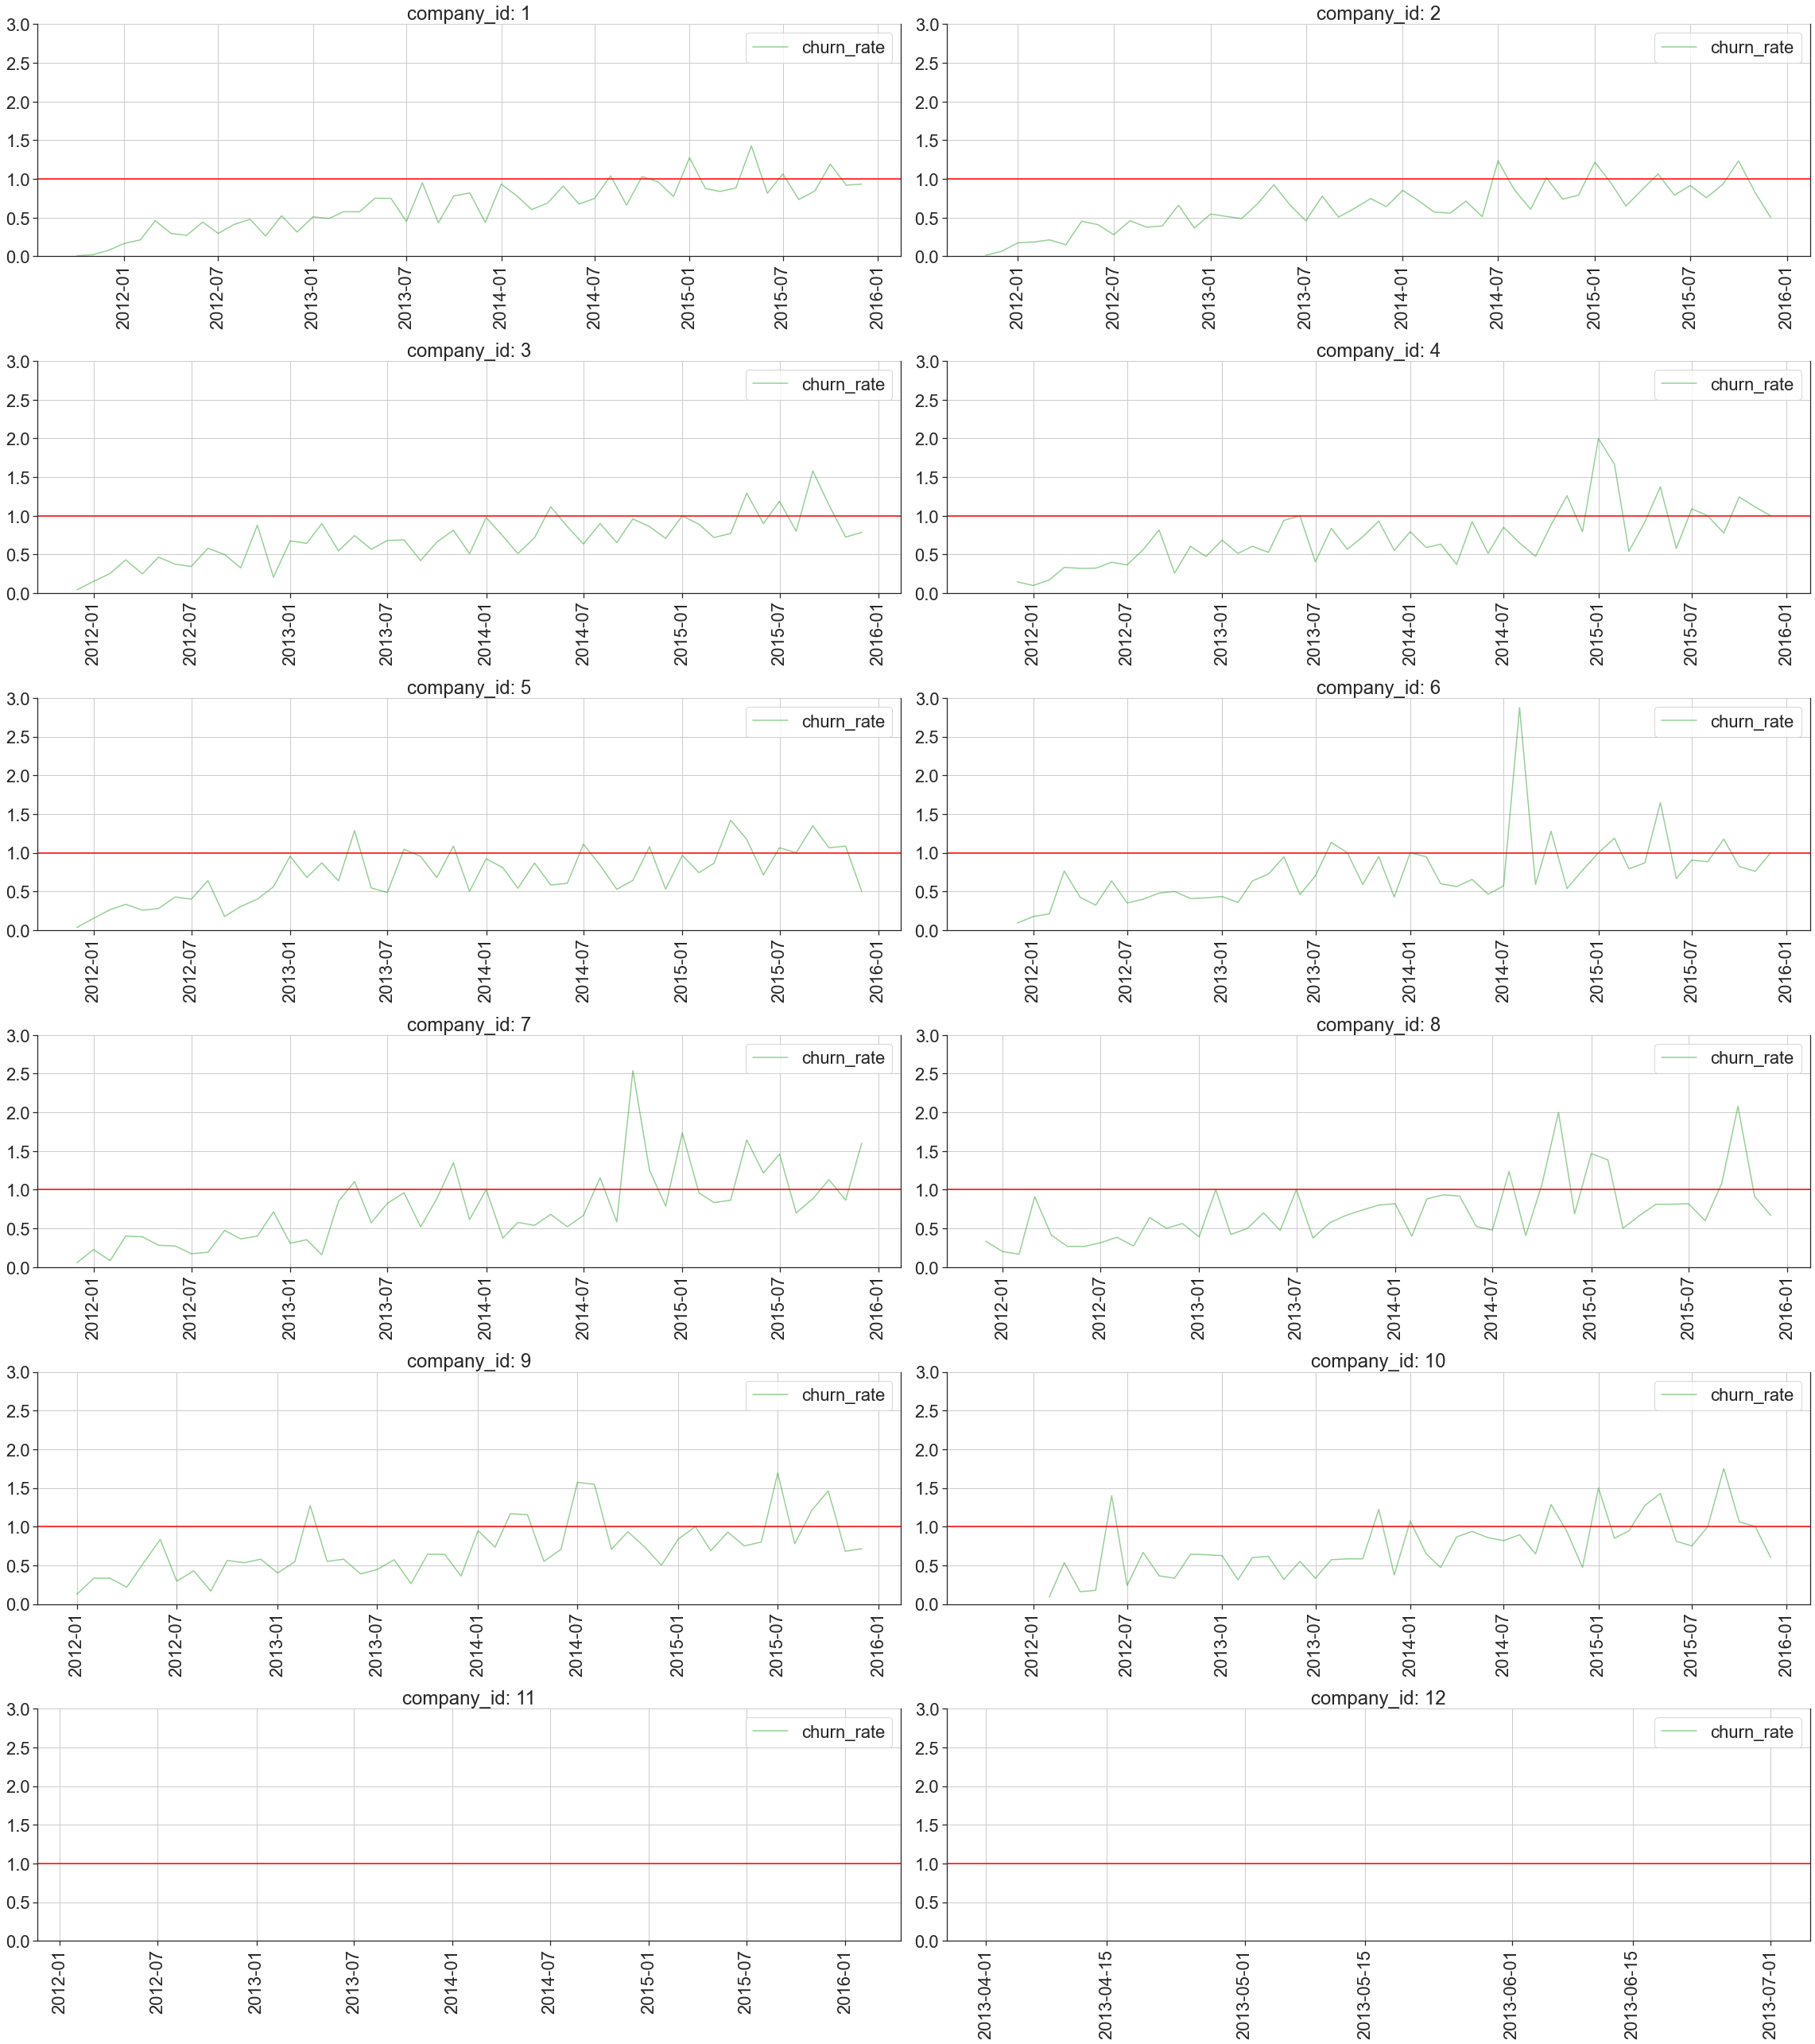

In [394]:
n_row = 6
n_col = 2
fig, ax = plt.subplots(n_row, n_col, figsize=(16*n_col,6*n_row))
for i, c in enumerate(df.company_id.value_counts().sort_index().index):
#     ax_ = ax[i//n_col, i % n_col].twinx()
    # the histogram of the data
    y1 = df[(df.company_id == c)].groupby([df.join_date.dt.year, df.join_date.dt.month]).count()["quit"]
    y2 = df[(df.quit == 1) & (df.company_id == c)].groupby([df.quit_date.dt.year, df.quit_date.dt.month]).count()["quit"]

    x1 = [pd.to_datetime(f"{int(x[0])}-{int(x[1])}") for x in y1.index]
    x2 = [pd.to_datetime(f"{int(x[0])}-{int(x[1])}") for x in y2.index]
    
    df1 = pd.DataFrame([x1, y1]).T
    df1.index = x1

    df2 = pd.DataFrame([x2, y2]).T
    df2.index = x2
    
    df3 = df2[1].div(df1[1])
    
    ax[i//n_col, i % n_col].plot(df3.index, df3.values, color = '#2ca02c', alpha=0.5, label="churn_rate")
    
    ax[i//n_col, i % n_col].set_title(f"company_id: {c}")
    ax[i//n_col, i % n_col].legend()
    ax[i//n_col, i % n_col].grid(True)
    ax[i//n_col, i % n_col].tick_params(axis='x', rotation=90)
    ax[i//n_col, i % n_col].axhline(y=1, color="red")
    ax[i//n_col, i % n_col].set_ylim(0, 3)
plt.tight_layout()

## Modeling

In [6]:
# Re-design the dataset for tabnet
# concat dataframes
df_le = df.copy(deep=True)
df_le = df_le[df_le.seniority < 90]
df_le["join_year"] = df_le["join_date"].dt.year
df_le["join_month"] = df_le["join_date"].dt.month
cat_features = ["company_id", "dept"]

for idx, f in enumerate(cat_features):
    print(f"Label Encoding for: {f}")
    lb = pd.Categorical(df_le[f])
    map_dict = {i: c for i, c in enumerate(lb.categories)}
    print(f"Mapping: {map_dict}")
    df_le[f"{f}_lb"] = lb.codes
    cat_features[idx] = f"{f}_lb"

# define features & target
features = ["seniority", "salary"] + cat_features
target = ["job_days"]

# split_date = pd.to_datetime('2015-12-13') - timedelta(days=365)
# X_train, y_train = df_le[df_le.join_date <= split_date][features], df_le[df_le.join_date <= split_date][target]
# X_test, y_test = df_le[df_le.join_date > split_date][features], df_le[df_le.join_date > split_date][target]

# X_train, X_test, y_train, y_test = train_test_split(df_le[features], df_le[target], test_size=0.1, random_state=42)
X_train, y_train = df_le[df_le.quit > 0][features], df_le[df_le.quit > 0][target]
cat_idxs = [list(X_train.columns).index(f) for f in cat_features]
cat_dims = [X_train[f].value_counts().index.shape[0]for f in cat_features]

Label Encoding for: company_id
Mapping: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12}
Label Encoding for: dept
Mapping: {0: 'customer_service', 1: 'data_science', 2: 'design', 3: 'engineer', 4: 'marketing', 5: 'sales'}


In [9]:
class ModelConfigsSettings(BaseSettings):
    """Config for prediction models' parameters."""
    # specify your configurations as a dict
    lgb_params: dict = {
        'boosting_type': 'rf',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 63,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
    }
    early_stopping_rounds: int = 50
    num_boost_round: int = 50
model_config = ModelConfigsSettings()
model_config.lgb_params["categorical_features"] = cat_idxs

In [15]:
# create lgb dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(
    X_train, y_train, reference=lgb_train)
# evals_result = {}
gbm_or = lgb.train(model_config.lgb_params,
                                lgb_train,
                                num_boost_round=model_config.num_boost_round,
                                valid_sets=lgb_eval
#                    , early_stopping_rounds=model_config.early_stopping_rounds,
#                                 callbacks=[
#                                     lgb.record_evaluation(evals_result)
#                                 ]
                )

[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 13508, number of used features: 4
[LightGBM] [Info] Start training from score 613.430560
[LightGBM] [Warning] Unknown parameter: categorical_features
[1]	valid_0's rmse: 321.698
[2]	valid_0's rmse: 321.698
[3]	valid_0's rmse: 321.698
[4]	valid_0's rmse: 321.698
[5]	valid_0's rmse: 321.698
[6]	valid_0's rmse: 320.763
[7]	valid_0's rmse: 320.292
[8]	valid_0's rmse: 320.046
[9]	valid_0's rmse: 319.92
[10]	valid_0's rmse: 319.859
[11]	valid_0's rmse: 319.559
[12]	valid_0's rmse: 319.375
[13]	valid_0's rmse: 319.265
[14]	valid_0's rmse: 319.206
[15]	valid_0's rmse: 319.179
[16]	valid_0's rmse: 319.057
[17]	valid_0's rms

Plotting feature importances...


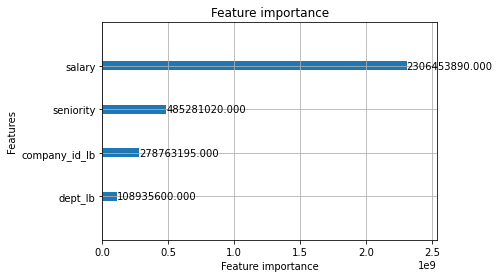

In [11]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm_or, importance_type="gain")
plt.show()

In [12]:
explainer = shap.Explainer(gbm_or, X_train)
shap_values = explainer(X_train)

 97%|=================== | 13167/13508 [00:17<00:00]       

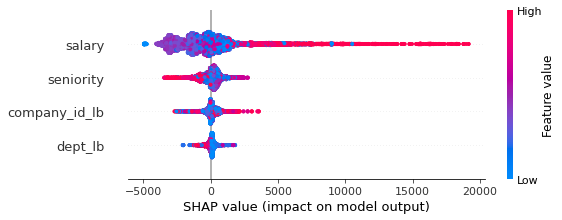

In [14]:
shap.plots.beeswarm(shap_values)

- 雖然使用的是lightgbm接口，但主要的boosting_type是以random forest為主
   - 主要想找關鍵因子，並非要做一個未來使用inference model
   - 全部的資料拿來train (主要作為分析，並非inference model)
   - 若要做inference model需要注意data leak問題 (切train/test時要以時間切割)，不能在訓練時得知未來的資訊
- 訓練目標：job_days 
    - 想關查那些job_days越長的人，有哪些特性 （反之，什麼因素導致那些job_days短的人要離職？）
    - 從feature importance (lgb內建)，跟shap可以看出，比較明顯的因素為salary (趨勢：薪水越高待越久), seniority (年資到一定位置時，會想離職？)

# Q2
What are the main factors that drive employee churn? Do they make sense? Explain your findings.
- 薪水是主要因素，data_science, engineer薪水越高，越不容易離職，跟其他職業相反，猜測原因是：競爭力問題，其他職業相較於data_science, engineer平均薪資較低，所以可能會因為無法找到較有競爭力的薪水而選擇待在原公司，反之data_science, engineer因為基礎薪資就已經較其他職業高，所以當薪水上升到一定值時，要跳槽的難度就會提高，因此就反而會留著
- 另外有發現，年底離職率較低，可能跟年終相關（或假期），反之年初有離職潮
- 員工週年的時段也很重要，會發現大家會在滿週年的時候離職，原因是大部分公司會考慮週年可以拿到特定獎勵

# Q3
If you could add to this data set just one variable that could help explain employee churn, what would that be?
- 根據經驗，我認為應該考慮更多時序變數 （陸續觀察這個員工的狀況）
    - 員工逐年績效(KPI, OKR等)狀況 ，間接影響到薪資（加薪幅度，績效獎金都會影響，也可以放入）
    - 部門逐月（年）人數，把公司headcount細分成部門，更容易觀察狀況（有時候部門狀況、氣氛，更能反應員工狀況
    - 逐步收集員工狀況：可以透過定期觀察員工回饋（ex: 問卷），觀察員工的工作狀態
    - 逐日上下班狀況：若有打卡記錄，也可以知道員工的工時（是不是爆炸工時，或是有沒有逐漸減少工時的狀況）
    - 公司、部門逐年營收：員工可能會因此感受到不安性，導致會想離職
    - 薪資競爭力：觀察同等職位，在其他公司的薪資待遇